# Question formulation Notebook

Use of toy dataset and notebook dependencies.

### Notebook Set-up:

In [33]:
import re
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from os import path
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType


In [77]:
warnings.filterwarnings('ignore')
# warnings.resetwarnings()
PWD = !pwd
PWD = PWD[0]

In [4]:
from pyspark.sql import SparkSession
app_name = "w261-FinalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

/opt/anaconda/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 952 is still running
  ResourceWarning, source=self)


In [3]:
# read the RDDs to see the form:
trainRDD = sc.textFile("gs://w261_final-project_team13/train.txt")
testRDD = sc.textFile("gs://w261_final-project_team13/test.txt")

In [4]:
trainRDD.take(2)

Py4JJavaError: An error occurred while calling o32.partitions.
: java.io.IOException: No FileSystem for scheme: gs
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:2660)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:2667)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:94)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:2703)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:2685)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:373)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:295)
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:258)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:229)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:315)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:200)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [19]:
testRDD.take(2)

['\t29\t50\t5\t7260\t437\t1\t4\t14\t\t1\t0\t6\t5a9ed9b0\ta0e12995\ta1e14474\t08a40877\t25c83c98\t\t964d1fdd\t5b392875\ta73ee510\tde89c3d2\t59cd5ae7\t8d98db20\t8b216f7b\t1adce6ef\t78c64a1d\t3ecdadf7\t3486227d\t1616f155\t21ddcdc9\t5840adea\t2c277e62\t\t423fab69\t54c91918\t9b3e8820\te75c9ae9',
 '27\t17\t45\t28\t2\t28\t27\t29\t28\t1\t1\t\t23\t68fd1e64\t960c983b\t9fbfbfd5\t38c11726\t25c83c98\t7e0ccccf\tfe06fd10\t062b5529\ta73ee510\tca53fc84\t67360210\t895d8bbb\t4f8e2224\tf862f261\tb4cc2435\t4c0041e5\te5ba7672\tb4abdd09\t21ddcdc9\t5840adea\t36a7ab86\t\t32c7478e\t85e4d73f\t010f6491\tee63dd9b']

We see that both are tab-separated files, so we want to sample them into a single-node computation friendly file and get back to the local machines. For that we need to know how many observations we have:

In [20]:
print('Train dataset count:', trainRDD.count(), 'observations.')
print('Test dataset count:', testRDD.count(), 'observations.')

Train dataset count: 45840617 observations.
Test dataset count: 6042135 observations.


Based on that we will take 0.3% of the dataset as sample, which will be roughly $45.840.617 \cdot 0.0003 = 137.521$ observations and $10.38E3 \cdot 0.0003 = 30$ MB, perfectly handle in a single node machine and still relevant. For the test dataset the same smaple ratio will be kept.

Another point is that the text file do not have headers, and as we want to work with dataframes, we want to create a schema. To do that we may take a look at the `readme.txt` file supplied with the data:

```
====================================================

Format:

The columns are tab separeted with the following schema:
<label> <integer feature 1> ... <integer feature 13> <categorical feature 1> ... <categorical feature 26>

When a value is missing, the field is just empty.
There is no label field in the test set.

====================================================
```

Additionally we need to parse the data, going from lines of strings to integers and and strings. For that we can map the RDD after sampling and converting to the desired type:

In [7]:
labelsTrain = ['label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
               'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
               'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

labelsTest = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
              'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
              'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

toyTrainDF = trainRDD.sample(False, 0.003, 2019).map(lambda line: line.split('\t')).toDF(labelsTrain)
toyTestDF = testRDD.sample(False, 0.003, 2019).map(lambda line: line.split('\t')).toDF(labelsTest)

Py4JJavaError: An error occurred while calling o32.partitions.
: java.io.IOException: No FileSystem for scheme: gs
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:2660)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:2667)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:94)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:2703)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:2685)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:373)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:295)
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:258)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:229)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:315)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:200)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [42]:
# verifying the count:
print('Toy train dataframe count:', toyTrainDF.count())
print('Toy test dataframe count:', toyTestDF.count())

Toy train dataframe count: 137139
Toy test dataframe count: 18181


In [44]:
# Now writing out toy datasets to be able to work on local machines
toyTrainDF.write.parquet("gs://w261_final-project_team13/toy_train.txt")
toyTestDF.write.parquet("gs://w261_final-project_team13/toy_test.txt")

Py4JJavaError: An error occurred while calling o219.parquet.
: java.io.IOException: No FileSystem for scheme: gs
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:2660)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:2667)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:94)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:2703)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:2685)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:373)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:295)
	at org.apache.spark.sql.execution.datasources.DataSource.planForWritingFileFormat(DataSource.scala:452)
	at org.apache.spark.sql.execution.datasources.DataSource.planForWriting(DataSource.scala:548)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:278)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:267)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:225)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:547)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


### Now running on the local machine:

In [5]:
# copy the files to the local machine:
!gsutil -m cp gs://w261_final-project_team13/toy_test.txt/* .data/toy_test.txt/
!gsutil -m cp gs://w261_final-project_team13/toy_train.txt/* .data/toy_train.txt/
gsutil cp gs://w261_final-project_team13/notebooks/* ./QuestionFormulation.ipynb

SyntaxError: invalid syntax (<ipython-input-5-fdda63bdac3f>, line 4)

In [130]:
# read the parquet files and print the first observations of each:
toyTrainDF = spark.read.parquet("./data/toy_train.txt")
toyTestDF = spark.read.parquet("./data/toy_test.txt")

In [6]:
toyTrainDF.head()

Row(label='0', I1='1', I2='2', I3='17', I4='3', I5='685', I6='16', I7='2', I8='3', I9='7', I10='1', I11='2', I12='1', I13='3', C1='05db9164', C2='38a947a1', C3='78c2dcf9', C4='041c8b35', C5='4cf72387', C6='6f6d9be8', C7='94aa68fb', C8='1f89b562', C9='a73ee510', C10='ac25feb9', C11='577aa337', C12='5b91fbfa', C13='f405e2e8', C14='07d13a8f', C15='a8041309', C16='15913bcf', C17='3486227d', C18='998b9a30', C19='', C20='', C21='3e2fae11', C22='', C23='32c7478e', C24='09a589c1', C25='', C26='')

In [7]:
toyTestDF.head()

Row(I1='', I2='-1', I3='', I4='', I5='8124', I6='62', I7='5', I8='1', I9='37', I10='', I11='1', I12='', I13='', C1='05db9164', C2='08c2f5df', C3='dde182a0', C4='de1dc0c1', C5='25c83c98', C6='fbad5c96', C7='ad3508b1', C8='0b153874', C9='a73ee510', C10='965e1030', C11='ad757a5a', C12='7a27d4e1', C13='93b18cb5', C14='1adce6ef', C15='a43baafd', C16='84534f54', C17='e5ba7672', C18='29b0e3e5', C19='', C20='', C21='2b81e06c', C22='c9d4222a', C23='423fab69', C24='2f647dfe', C25='', C26='')

We see that all features are strings. We want to cast the `label` feature to _Boolean_ and the `I1` to `I13` features to _integers_:

In [131]:
toyTrainDF = toyTrainDF.withColumn('label', toyTrainDF.label.cast('Boolean'))

intColumns = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']

# convert to number. Cast to float to be able to use NaN:
for column in intColumns: 
    toyTrainDF = toyTrainDF.withColumn(column, F.when(toyTrainDF[column] != "", toyTrainDF[column].cast('float')).otherwise(float('NaN')))
    toyTestDF = toyTestDF.withColumn(column, F.when(toyTestDF[column] != "", toyTestDF[column].cast('float')).otherwise(float('NaN')))
    
strColumns = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
              'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']
for column in strColumns:
    toyTrainDF = toyTrainDF.withColumn(column, F.when(toyTrainDF[column] != "", toyTrainDF[column]).otherwise(None))
    toyTestDF = toyTestDF.withColumn(column, F.when(toyTestDF[column] != "", toyTestDF[column]).otherwise(None))

In [132]:
toyTrainDF.head()

Row(label=False, I1=1.0, I2=2.0, I3=17.0, I4=3.0, I5=685.0, I6=16.0, I7=2.0, I8=3.0, I9=7.0, I10=1.0, I11=2.0, I12=1.0, I13=3.0, C1='05db9164', C2='38a947a1', C3='78c2dcf9', C4='041c8b35', C5='4cf72387', C6='6f6d9be8', C7='94aa68fb', C8='1f89b562', C9='a73ee510', C10='ac25feb9', C11='577aa337', C12='5b91fbfa', C13='f405e2e8', C14='07d13a8f', C15='a8041309', C16='15913bcf', C17='3486227d', C18='998b9a30', C19=None, C20=None, C21='3e2fae11', C22=None, C23='32c7478e', C24='09a589c1', C25=None, C26=None)

In [133]:
toyTestDF.head()

Row(I1=nan, I2=-1.0, I3=nan, I4=nan, I5=8124.0, I6=62.0, I7=5.0, I8=1.0, I9=37.0, I10=nan, I11=1.0, I12=nan, I13=nan, C1='05db9164', C2='08c2f5df', C3='dde182a0', C4='de1dc0c1', C5='25c83c98', C6='fbad5c96', C7='ad3508b1', C8='0b153874', C9='a73ee510', C10='965e1030', C11='ad757a5a', C12='7a27d4e1', C13='93b18cb5', C14='1adce6ef', C15='a43baafd', C16='84534f54', C17='e5ba7672', C18='29b0e3e5', C19=None, C20=None, C21='2b81e06c', C22='c9d4222a', C23='423fab69', C24='2f647dfe', C25=None, C26=None)

Now, we can start analyzing the data to understand which features are more likely to contribute to a model and which are more likely to bias our model (due to a high number of `None` values or that need normalization, for example.

## EDA

As we are not sure which any of the variables means, we need to take a look on each and every one trying to understand if it is valuable for the click-through rate. We can check what is the overall rate for the whole dataset and as a baseline and see which are better than the baseline and which are worst:

In [138]:
# check the overall rate:
totalCount = toyTrainDF.count()
truePerc = toyTrainDF.filter(toyTrainDF.label == True).count()/totalCount
print('Overall click-through rate: {0:3.2f}%'.format(truePerc*100))

# none count in label feature:
noneCount = toyTrainDF.filter(toyTrainDF.label == float('NaN')).count()
print('Overall click-through count: {0:d}. This represents {1:3.2f}% of the dataset.'.format(noneCount,noneCount/totalCount*100))

Overall click-through rate: 25.68%
Overall click-through count: 0. This represents 0.00% of the dataset.


As we have 39 features, it is a good idea to verify each one for its effectiveness, checking count of values, distributions, etc. For the numeric variables we have the describe function, but we also wants to verify None value count and the most frequent variables count:

In [139]:
def descNumEDA(dataframe, column, totalCount=0, nanThreshold=0.5):
    """
    Function that prints an analysis of column from the given dataframe. Retuns None.
    Args:
        dataframe    - input dataframe
        column       - string with a dataframe column.
        totalCount   - optional. Number of rows in the dataframe (if defined avoid recalculation).
        nanThreshold - optional. Percentage allowed of NaN values in the column.
    Returns:
        Column       - name of the column if the column have more NaN if it represents more 
                       than nanThreshold ratio.
    Output:
        NaN Count    - number for NaN values in % of the row count of the dataframe.
        Mean         - mean of the valid entries
        StdDev       - standard deviation of the valid entries
        Max          - maximum value of the valid entries
        3rd Quartile - 75% quartile od the 
        Median       - 50% quartile of the valid entries
        1st Quartile - 25% of the valid entries
        Min          - minimum value of the valid entries
        Most Freq    - number of values for the 5 most frequent values
        
    """
    if totalCount == 0:
        totalCount = dataframe.count()
    
    pandCol = dataframe.select(column).toPandas()[column]
    freqNumbers = dict(pandCol.value_counts(normalize=True).head(5))
    
    nanCount = dataframe.filter(F.isnan(dataframe[column])).count()
    
    validCount = totalCount - nanCount
    
    print('+'+13*'-'+'+'+30*'-'+'+')
    print('|Feature: {:^4}'.format(column)+'|{:>22}{:>6.2f}% |'.format('Null Count: ', nanCount/totalCount*100))
    print('+'+13*'-'+'+'+30*'-'+'+')
    print('|{:>12} |{:>29.2f} |'.format('Mean', pandCol.mean()))
    print('|{:>12} |{:>29.2f} |'.format('StdDev', pandCol.std()))
    print('|{:>12} |{:>29.2f} |'.format('Maximum', pandCol.max()))
    print('|{:>12} |{:>29.2f} |'.format('3rd Quartile', pandCol.quantile(q=0.75)))
    print('|{:>12} |{:>29.2f} |'.format('Median', pandCol.quantile(q=0.5)))
    print('|{:>12} |{:>29.2f} |'.format('1st Quartile', pandCol.quantile(q=0.25)))
    print('|{:>12} |{:>29.2f} |'.format('Minimum', pandCol.min()))
    print('|{:>12} |{:>29.2f} |'.format('Unique Val.', pandCol.nunique()))
    print('+'+13*'-'+'+'+30*'-'+'+')
    print('| Most Freq.: {:>30} |'.format(str(list(freqNumbers.keys()))))
    print('+'+13*'-'+'+'+30*'-'+'+')
    for item in freqNumbers:
        print('|{:>12} |{:>28.2f}% |'.format(item, freqNumbers[item]*100))
    print('+'+13*'-'+'+'+30*'-'+'+\n')
    
    if nanCount/totalCount*100 > nanTreshold*100:
        return column
    else:
        return None

In [140]:
badFeatures = []
nanTreshold = 0.4

for item in intColumns:
    badFeatures.append(descNumEDA(toyTrainDF, item, totalCount, nanTreshold))

badFeatures = list(filter(None,badFeatures))
print('List of feature with more than {:4.2f}% NaN ratio: {}'.format(nanTreshold*100, badFeatures))

+-------------+------------------------------+
|Feature:  I1 |          Null Count:  45.09% |
+-------------+------------------------------+
|        Mean |                         3.52 |
|      StdDev |                         9.13 |
|     Maximum |                       425.00 |
|3rd Quartile |                         3.00 |
|      Median |                         1.00 |
|1st Quartile |                         0.00 |
|     Minimum |                         0.00 |
| Unique Val. |                       156.00 |
+-------------+------------------------------+
| Most Freq.:      [0.0, 1.0, 2.0, 3.0, 4.0] |
+-------------+------------------------------+
|         0.0 |                       42.56% |
|         1.0 |                       17.66% |
|         2.0 |                        9.69% |
|         3.0 |                        5.93% |
|         4.0 |                        4.40% |
+-------------+------------------------------+

+-------------+------------------------------+
|Feature:  I

Overall, we see that most features are right skewed, with most of its values near zero. Additionally we were able to identify features with a lot of `NaN` values. This analisys will be usefull in the future when deciding which algorithm we want to use. Another consideration when picking algorithms would be multicolinearity. For that we ran a scatterplot matrix where we can check that:

Now, doing a similar analisys for the categorical values, we have:

In [143]:
def descCatEDA(dataframe, column, totalCount=0, nanThreshold=0.5):
    """
    Function that prints an analysis of column from the given dataframe. Retuns None.
    Args:
        dataframe    - input dataframe
        column       - string with a dataframe column.
        totalCount   - optional. Number of rows in the dataframe (if defined avoid recalculation).
        nanThreshold - optional. Percentage allowed of NaN values in the column.
    Returns:
        Column       - name of the column if the column have more NaN if it represents more 
                       than nanThreshold ratio.
    Output:
        NaN Count    - number for NaN values in % of the row count of the dataframe.
        Most Freq    - number of values for the 5 most frequent values (discarding NaN).
        
    """
    if totalCount == 0:
        totalCount = dataframe.count()
    
    pandCol = dataframe.select(column).toPandas()[column]
    freqNumbers = dict(pandCol.value_counts(normalize=True).head(5))
    
    nanCount = dataframe.filter(dataframe[column].isNull()).count()
    
    validCount = totalCount - nanCount
    
    print('+'+13*'-'+'+'+22*'-'+'+')
    print('|Feature: {:^4}'.format(column)+'|{:>14}{:>6.2f}% |'.format('Null Count: ', nanCount/totalCount*100))
    print('+'+13*'-'+'+'+22*'-'+'+')
    print('| Unique Values: {:>19} |'.format(pandCol.nunique()))
    print('+'+13*'-'+'+'+22*'-'+'+')
    for item in freqNumbers:
        print('|{:>12} |{:>20.2f}% |'.format(item, freqNumbers[item]*100))
    print('+'+13*'-'+'+'+22*'-'+'+\n')
    
    if nanCount/totalCount*100 > nanTreshold*100:
        return column
    else:
        return None

In [144]:
for item in strColumns:
    badFeatures.append(descCatEDA(toyTrainDF, item, totalCount, nanTreshold))

badFeatures = list(filter(None,badFeatures))
print('List of feature with more than {:4.2f}% NaN ratio: {}'.format(nanTreshold*100, badFeatures))

+-------------+----------------------+
|Feature:  C1 |  Null Count:   0.00% |
+-------------+----------------------+
| Unique Values:                 616 |
+-------------+----------------------+
|    05db9164 |               50.04% |
|    68fd1e64 |               16.78% |
|    5a9ed9b0 |                8.39% |
|    8cf07265 |                4.97% |
|    be589b51 |                3.28% |
+-------------+----------------------+

+-------------+----------------------+
|Feature:  C2 |  Null Count:   0.00% |
+-------------+----------------------+
| Unique Values:                 528 |
+-------------+----------------------+
|    38a947a1 |               11.35% |
|    207b2d81 |                4.29% |
|    38d50e09 |                3.80% |
|    1cfdf714 |                3.67% |
|    287130e0 |                3.54% |
+-------------+----------------------+

+-------------+----------------------+
|Feature:  C3 |  Null Count:   3.45% |
+-------------+----------------------+
| Unique Values:       

Now let's check for correlations between integer variables, as this can be harmfull to some algorithms like logistic regression. We will take an approx. 1000 observation sample and normalize the columns to improve visualization.

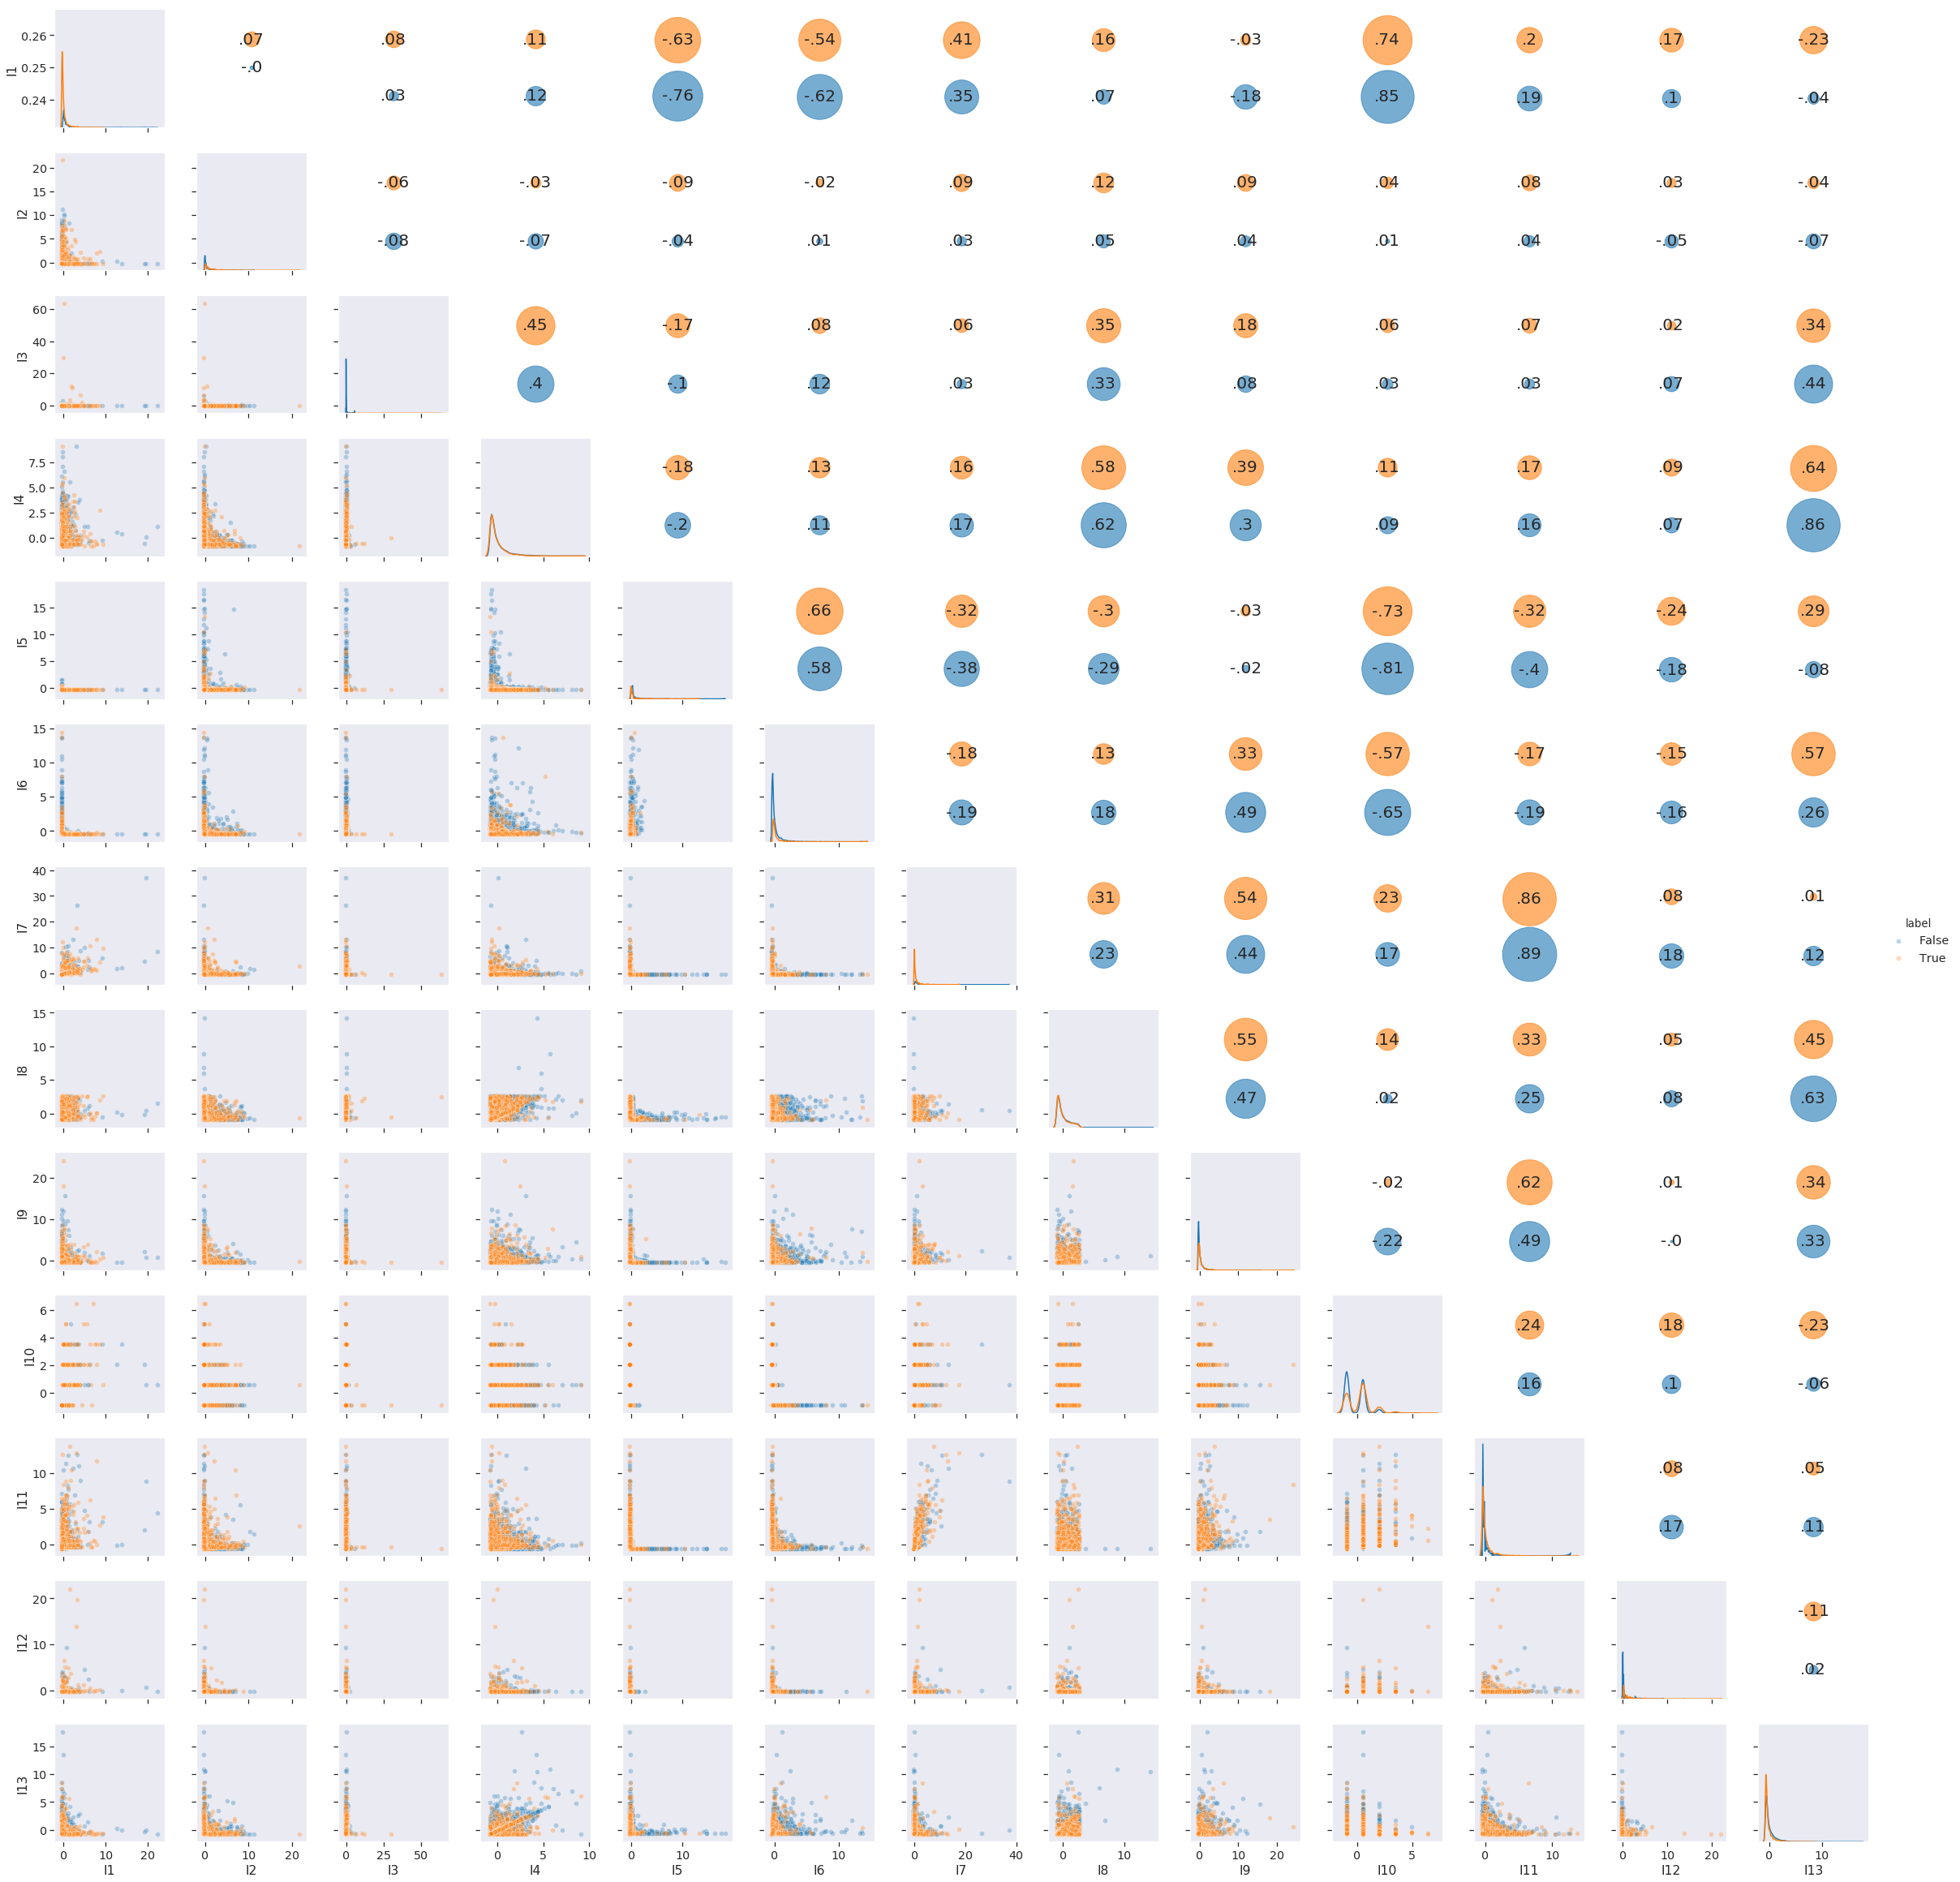

In [49]:
# I'll sample again to improve visualization:

def corrdot(*args, **kwargs):
    """
    Helper function to plot correlation indexes in the upper side of the scatterplot matrix.
    Reference: https://github.com/mwaskom/seaborn/issues/1444
    """
    corr_r = args[0].corr(args[1], 'spearman')
    # Axes
    ax = plt.gca()
    ax.axis('off')
    x_min, x_max = ax.get_xlim()
    x_centroid = x_min + (x_max - x_min) / 2
    y_min, y_max = ax.get_ylim()
    y_true = y_max - (y_max - y_min) / 4
    y_false = y_min + (y_max - y_min) / 4
    # Plot args
    if kwargs['label'] == True:
        marker_size = abs(corr_r) * 5000
        ax.scatter(x_centroid, y_true, marker='o', s=marker_size, alpha=0.6)
        corr_text = str(round(corr_r, 2)).replace('-0', '-').lstrip('0')
        ax.annotate(corr_text, [x_centroid, y_true,], ha='center', va='center', fontsize=20)
    else:
        marker_size = abs(corr_r) * 5000
        ax.scatter(x_centroid, y_false, marker='o', s=marker_size, alpha=0.6)
        corr_text = str(round(corr_r, 2)).replace('-0', '-').lstrip('0')
        ax.annotate(corr_text, [x_centroid, y_false,], ha='center', va='center', fontsize=20)

# name of the integer columns for normalization and pairgrid:
int_columns_list = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']

# normalizing the DF, keeping the label column and using OBS - MEAN/STDDEV:
vizDF = toyTrainDF.sample(False, 0.05, 2019).toPandas().iloc[:,0:14]
vizDF_norm = pd.DataFrame(vizDF[int_columns_list].values, columns=int_columns_list, index=vizDF.index)
vizDF_norm = (vizDF_norm - vizDF_norm.mean())/vizDF_norm.std()
vizDF[int_columns_list] = vizDF_norm

# ploting the results splited by label:
sns.set_context('notebook', font_scale=1.3)
g = sns.PairGrid(vizDF, vars=int_columns_list, hue='label')
g.map_lower(sns.scatterplot, alpha=0.3)
g.map_diag(sns.distplot, hist=False)
g.map_upper(corrdot)
g.add_legend()



Note that most variables doesn't are correlated equaly both for False labels and True labels. This will be important when taking decisions on dropping or encoding features. Another important point is the presence of outliers, with observations up to 40 standard deviations of the mean (as saw with `I7`). Those will be notes that will be taken in consideration when choosing the learning algorithm to train our model.

Finally, after analyzing the features of our dataset, we can analyze if some of our observations contains bad data. As no information is provided about the features, our only possible approach is to count missing values within each observation and see it's influence on the click prediction:


In [134]:
# checking the average NaN count in each row:
toyTrainPandasDF = toyTrainDF.toPandas()
countNullDF = toyTrainPandasDF.isnull().sum(axis=1).rename('CountNaN')
countNullDF.describe()

count    137139.000000
mean          5.544265
std           3.424073
min           0.000000
25%           3.000000
50%           5.000000
75%           8.000000
max          23.000000
Name: CountNaN, dtype: float64

In [137]:
# concat dataframes and crosstab 
countNullDF = pd.concat([toyTrainPandasDF['label'], countNullDF], axis=1)
countNullDF.groupby('label').mean()

,CountNaN
label,
False,5.649304
True,5.240224


We see that the count of missing values is higher in non-clicks, but the difference is small, so the absence of values is not a good indicator for CTR.

With the information gathered here, we can now move to algorithm selection.